#El uso del resumen para la construccion de un clasificador de sentimiento

Dado que el enfoque que tomaré para mi Tesis es la construcción de un clasificador de ideología política a partir de opiniones o tweets, consideré una buena oportunidad el utilizar las técnicas vistas en esta optativa como un punto de inicio e incluso un Baseline para mi Tesis.

Cargamos la direccion donde almacenamos nuestros datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Conjunto de datos

Dentro de la libreria "datasets" se encuentra un conjunto de reseñas de Amazon en español, la cual nos provee de un titulo, review, puntuacion y categoría del producto


In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
from datasets import load_dataset, get_dataset_config_names
from IPython.display import display, HTML

#Tomamos el nombre del conjunto de opiniones generales
dataset_name = "amazon_reviews_multi"
#Unicamente tomamos las que estan relacionadas al Español
dataset = load_dataset(path=dataset_name, name="es")
#Una vez cargadas le damos el formato de un dataframe de pandas
dataset.set_format("pandas")

#Tomamos el conjunto de entrenamiento
df = dataset["train"][:]
#sample = df.sample(n=8, random_state=42)
#display(HTML(sample.to_html()))

#tomamos el conjunto de prueba
df1=dataset['test'][:]

Descartamos las columnas que no nos interesan, y conservamos unicamente las relacionadas a la opinion, y las estrellas es decir qué tan positiva o negativa es la reseña.

In [ ]:
df=df.drop(columns=['review_id', 'product_id', 'reviewer_id', 'review_title', 'language', 'product_category'])

Obseerve que solo queda la calificación numerica de la opinión y el cuerpo de la opinón

In [ ]:
df.head()

,stars,review_body
0,1,Nada bueno se me fue ka pantalla en menos de 8...
1,1,"Horrible, nos tuvimos que comprar otro porque ..."
2,1,Te obligan a comprar dos unidades y te llega s...
3,1,"No entro en descalificar al vendedor, solo pue..."
4,1,Llega tarde y co la talla equivocada


##Muestreo

Vamos a tomar un conjunto de 20 mil opiniones para el entrenamiento de nuestros clasificadores, mientras que se toman 5 mil opiniones para el conjunto de prueba. Como tenemos 5 distintas cantidades de estrellas, entonces eso quiere decir que para el entrenamiento, se tienen que tomar 4 mil observaciones de cada cantidad de estrellas.


In [ ]:
#Tomamos los elementos del dataframe que coincidan con ese numero de estrellas
unos=df[df['stars']==1].sample(4000)
dos=df[df['stars']==2].sample(4000)
tres=df[df['stars']==3].sample(4000)
cuatro=df[df['stars']==4].sample(4000)
cinco=df[df['stars']==5].sample(4000)

#Creamos el nuevo dataframe correspondiente y le damos el formato necesario
df=pd.concat([unos,dos,tres,cuatro,cinco], axis=0)
df=df.reset_index().drop(columns=['index'])

## **Criterio para el sentimiento**

Lo que queremos hacer, es convertir elementos de este conjunto de datos en un atributo  util para clasificar las opiniones de algunos clientes para saber si la opinion es **positiva o negativa**:

* **Una opinion es positiva si cuenta con 3 o mas estrellas**
* **Una opinion es negativa si cuenta con 2 o menos estrellas**

In [ ]:
rate=np.where(df['stars']< 3 , 1, 0)
df['class']=rate

In [ ]:
rate=[]
for i in range(df.shape[0]):
  if(df['stars'][i] < 3):
    rate.append(0)
  else:
    rate.append(1)
df['class']=rate
df.head()

,stars,review_body,class
0,1,no me llego el articulo me lo mando por correo...,0
1,1,"la mensajería horrible, no compro mas",0
2,1,Estoy muy decepcionado con el vendedor ya que ...,0
3,1,Mi valoración no es sobre el producto sino sob...,0
4,1,Pues tenía interés en este libro y probé la ve...,0


##Preprocesamiento de las opiniones

Vamos a preprocesar nuestros textos, en este caso trabajaremos unicamente con:
* Todas las palabras pasan a minúsculas
* Al no necesitar hipervinculos, emojis, se conservan únicamente caracteres alfanuméricos
* Se descarta la idea de remover las stopwords, debido a que podríamos perder información importante

Para hacer todo esto se habia hecho manualmente, pero al ser posible el paralelilzarlo se usa ese recurso, disminuyendo la ejecucion de 5 min a menos de 30 segundos.

**Instalacion del contexto spark**

In [ ]:
#resumen=[generate_summary(texto) for texto in df['Procesado']]
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
# install findspark using pip
!pip install -q findspark

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext()

In [ ]:
#En su mayoria usamos los elementos de la libreria NLTK para todo el preprocesamiento y tokenizacion
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Funcion que toma como entrada un string y lo devuelve procesado

In [ ]:
def procesar(texto):
  texto=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', texto )
  text_tokens = word_tokenize(texto)
  tokens_without_sw = [word.lower() for word in text_tokens if word.isalpha()]
  return(' '.join(tokens_without_sw))

*Paralelizamos el objeto que contiene las opiniones que queremos procesar*

In [ ]:
x_rdd=sc.parallelize(df['review_body'])

Guardamos las opiniones procesadas

In [ ]:
review=x_rdd.map(procesar).collect()

**Ejemplo del preproceso**

In [ ]:
print(df['review_body'][100])
print(review[100])

Hola, no pone que cobran gastos de envío en la web y después si los cobran y vale muchos mas que el producto.
hola no pone que cobran gastos de envío en la web y después si los cobran y vale muchos mas que el producto


*El objeto actual luce algo asi:*

In [ ]:
df['Procesado']=review
df.head()

,stars,review_body,Procesado
0,1,"Es un plástico, no un hule como estoy acostumb...",es un plástico no un hule como estoy acostumbr...
1,1,"No aconsejo su compra, ya que es un producto o...",no aconsejo su compra ya que es un producto or...
2,1,El producto no corresponde con la imagen. No e...,el producto no corresponde con la imagen no el...
3,1,"En Bkool Pro 2, duran menos de 800 km, algo qu...",en bkool pro duran menos de km algo que la hac...
4,1,Siento decir que no me ha ayudado en nada. Tom...,siento decir que no me ha ayudado en nada toma...


##Análisis de las opiniones

Vamos a crear un objeto que nos ayude a almacenar las longitudes de las distintas reseñas

In [ ]:
#Una lista que para cada elemento en el dataframe almacene la longitud de la opinion procesada
longitud=[]
for i in range(df.shape[0]):
  longitud.append(len(df['Procesado'][i].split()))

#Otro camino
#longitud=[len(x.split()) for x in df['Procesado'] ]

In [ ]:
df['Longitud']=longitud
df.head()

,stars,review_body,Procesado,Longitud
0,1,"Es un plástico, no un hule como estoy acostumb...",es un plástico no un hule como estoy acostumbr...,16
1,1,"No aconsejo su compra, ya que es un producto o...",no aconsejo su compra ya que es un producto or...,21
2,1,El producto no corresponde con la imagen. No e...,el producto no corresponde con la imagen no el...,46
3,1,"En Bkool Pro 2, duran menos de 800 km, algo qu...",en bkool pro duran menos de km algo que la hac...,27
4,1,Siento decir que no me ha ayudado en nada. Tom...,siento decir que no me ha ayudado en nada toma...,26


Veamos mediante una gráfica de barras, en donde se acumulan estas longitudes

**No hay duda que solo una parte pequeña de todas las opiniones, apenas y supera las 100 palabras, por lo que se necesita alguna forma de uniformizar todos estos textos sin tener que descartar opiniones**

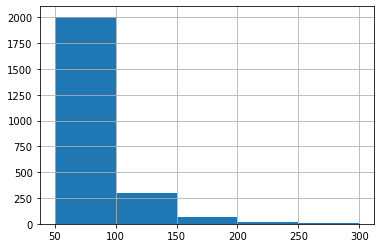

In [ ]:
df['Longitud'].hist(bins=[50,100,150,200,250,300])

**Dentro del intervalo de 10 a 100 palabras, incluso hay una gran diferencia acumulandose  por debajo de las 30 palabras, por lo cual el descartar observaciones no es una opción**

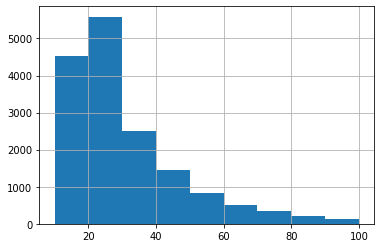

In [ ]:
df['Longitud'].hist(bins=[10,20,30,40,50,60,70,80,90,100])

In [ ]:
df.to_csv('/content/drive/MyDrive/DATA.csv')

##Propuesta

Así como existen técnicas de reducción de dimensión a nivel técnico o selección de características al tratar con matrices de datos numéricos, creo que se pueden usar otras técnicas que aprovechen la representación textual de las opiniones antes de obtener una representacion matricial de los mismos y aplicar otras técnicas


## Modelos de resumen automáticos basados en transformers

El obtener una representación mas corta de todas nuestras opiniones es una tarea que un modelo de Resúmen automático puede resolver y no solo eso sino que establece una longitud mínima y máxima de secuencias.

Los modelos basados en transformers están completamente basados en la atención, entonces es una buena pregunta si este tipo de modelos puede ajustarse a aquellos elementos realmente importantes de la opinón y no perder tanta información.

In [ ]:
!pip install transformers

##Modelo de resumen automático

El modelo elegido fue extraído de la comunidad de "Hugging face", el cual se trata de un modelo BERT adaptado para entrenarse con un corpus en Español, el cual se usó como baseline para otro trabajo, entonces me parece un buen punto de partida


In [ ]:
#Otra version que se logro, fue un fine tuned del modelo mencionado, basta con copiar la siguiente linea en la variable ckpt y parece tener mjores resultados
#EP9/bert2bert_shared-spanish-finetuned-summarization-finetuned-xsum

Las siguientes lineas son suficientes para utilizar el modelo

In [ ]:
import torch
from transformers import BertTokenizerFast, EncoderDecoderModel
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = 'mrm8488/bert2bert_shared-spanish-finetuned-summarization'
tokenizer = BertTokenizerFast.from_pretrained(ckpt)
model = EncoderDecoderModel.from_pretrained(ckpt).to(device)

Downloading:   0%|          | 0.00/520 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556M [00:00<?, ?B/s]

The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


**Se crea una función encargada de la mayor parte del trabajo, basta con pasarle el string que se busca resumir**

In [ ]:
def generate_summary(text):

   inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
   input_ids = inputs.input_ids.to(device)
   attention_mask = inputs.attention_mask.to(device)
   output = model.generate(input_ids, attention_mask=attention_mask)
   return tokenizer.decode(output[0], skip_special_tokens=True)


##Desventajas de la propuesta

No todo puede ser bueno, debido a que esta tarea por distintas pruebas en promedio tarda:

* Menos de 10 segundos si se usa GPU
* Menos de 1 minuto si solo se usa CPU

Por lo cual obviamente tenemos un problema al querer sacarle provecho a conjuntos de datos grandes, por ejemplo para las 20 mil observaciones en el peor de los casos tardaríamos en el peor de los casos 50 horas en GPU y ni hablar del otro caso.

##Uso de Spark como solución parcial

Tal y como lo vimos en el curso, si se encuentra una forma se puede paralelizar el proceso y utilizar las ventajas que nos da SPARK para solucionar este tipo de problemas. Mas adelante se describe el objeto que se paralelizó.

**Instalamos la paquetería y creamos nuestro contexto**

In [ ]:
#resumen=[generate_summary(texto) for texto in df['Procesado']]
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
# install findspark using pip
!pip install -q findspark

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext()

Observe que la columna del dataframe puede ser tomada como un objeto para ser paralelizado por SPARK renglón a renglón.

In [ ]:
df["Procesado"]

0        el producto ha dejado de funcionar y solo tien...
1        se rompe la tapa por la presión quiero una sol...
2        las agujas del reloj se mueven con el movimien...
3        no es la calidad que esperaba bueno por el pre...
4        la batería dura muy poco y falla bastante el a...
                               ...                        
19995    es muy bonito y simple de usar no necesita muc...
19996    muy contenta con la compra quedan preciosos yo...
19997    un producto moderno para mis clientes y diferente
19998    es muy cómoda la entrega muy mal te dicen un d...
19999    muy contenta con la compra vivo en un piso y v...
Name: Procesado, Length: 20000, dtype: object

Tomemos una opinión arbitrariamente para ver cómo funciona esta funciónÑ

In [ ]:
generate_summary(df["Procesado"][3591])

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


'La compré y cuando fuí a montarla le faltaban piezas asique la Deber revis sus pedidos ya que por lo que leo en los comentarios le a mas gente gente gente'

**Le pasamos la columna del dataframe correspondientes a los reviews procesados**

In [ ]:
X_rdd=sc.parallelize(df["Procesado"])
X_rdd.count()

20000

Parece que paralelizó el objeto como nos gustaría, entonces probemoslo

**Generamos los resúmenes usando la función antes declarada**

In [ ]:
X_res = X_rdd.map(generate_summary)

**Guardamos los resultados de la parelización**

In [ ]:
Resumido=X_res.collect()

La linea anterior fue la que realmente tardó, la cual tomó **Casi 5 horas en ejecutarse**

In [ ]:
resumenes=pd.DataFrame({'Resumido': Resumido})
resumenes.to_csv('/content/drive/MyDrive/resumenes_test.csv')

###Revisión de la paralelización

Imprimimos alguna observacion procesada

In [ ]:
df["Procesado"][19]

'al encender la impresora todo correcto hizo el auto ajuste bien seleccione el archivo del gato tardó horas en imprimir todo ok desde sd el problema viene cuando la quieres conectar al pc no la detecta después de buscar por internet no hay información de ella en ningún sitio nada de nada no puedes usar cura para hacer las impresiones después de varias horas parece que algo se conecta pero hace cosas raras el extrusor no deja de sacar pla y cuando va a hacer el auto ajuste se hunde en la cama dejándola destrozada parece que es una impresora de calidad pero me he llevado un chasco que no veas se monta muy rápido puro no se puede configurar así que la devolví'

Mostramos el Resumen correspondiente generad en la paralelización.

In [ ]:
Resumido[19]

'Me he llevado un chasco que no veas se monta muy rápido puro no se puede configurar así que la devolvína destrozada parece que es una impresora de calidad'

**Agregamos la versión resumida del conjunto de entrenamiento y prueba a las columnas de los dataframe**

In [ ]:
df["Resumido"]=Resumido
df.head()

,stars,review_body,class,Procesado,Longitud,Resumido
0,1,El producto ha dejado de funcionar y solo tien...,0,el producto ha dejado de funcionar y solo tien...,14,El producto ha dejado de funcionar y solo tien...
1,1,Se rompe la tapa por la presión. Quiero una so...,0,se rompe la tapa por la presión quiero una sol...,11,Se rompe la tapa por la presión quiero una sol...
2,1,Las agujas del reloj se mueven con el movimien...,0,las agujas del reloj se mueven con el movimien...,23,Las agujas del reloj se mueven con el movimien...
3,1,"no es la calidad que esperaba, bueno por el pr...",0,no es la calidad que esperaba bueno por el pre...,20,No es la calidad que esperaba bueno por el pre...
4,1,La batería dura muy poco y falla bastante el a...,0,la batería dura muy poco y falla bastante el a...,25,La batería dura muy poco y falla bastante el a...


### Efecto sobre las longitudes de las opiniones

In [ ]:
longitud2=[]

for i in range(df.shape[0]):
  longitud2.append(len(df['Resumido'][i].split()))
df['longitud_new']=longitud2

#Otro camino
#longitud2=[len(x.split()) for x in df['Resumido'] ]

In [ ]:
df.head()

,Unnamed: 0,stars,review_body,class,Procesado,Longitud,Resumido,longitud_new
0,0,1,El producto ha dejado de funcionar y solo tien...,0,el producto ha dejado de funcionar y solo tien...,14,El producto ha dejado de funcionar y solo tien...,14
1,1,1,Se rompe la tapa por la presión. Quiero una so...,0,se rompe la tapa por la presión quiero una sol...,11,Se rompe la tapa por la presión quiero una sol...,20
2,2,1,Las agujas del reloj se mueven con el movimien...,0,las agujas del reloj se mueven con el movimien...,23,Las agujas del reloj se mueven con el movimien...,18
3,3,1,"no es la calidad que esperaba, bueno por el pr...",0,no es la calidad que esperaba bueno por el pre...,20,No es la calidad que esperaba bueno por el pre...,20
4,4,1,La batería dura muy poco y falla bastante el a...,0,la batería dura muy poco y falla bastante el a...,25,La batería dura muy poco y falla bastante el a...,19


**Observe que las longitudes nuevas de alguna forma se ven un poco mas uniformes, alcanzando una longitud máxima de 70 palabras y teniendo densidades altas en casi todas esas clases**

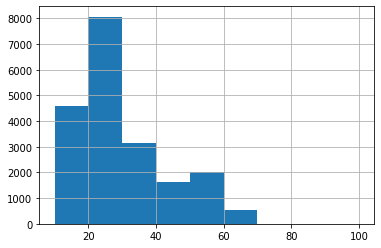

In [ ]:
df['longitud_new'].hist(bins=[10,20,30,40,50,60,70,80,90,100])

*Un problema con el que me encontre algo tarde es que las clases no estaban equilibradas, por lo que reduje a la clase mas densa a la misma cantidad que la menos densa*

In [ ]:
X_train=pd.read_csv('/content/drive/MyDrive/Train_Completo.csv')
X_train=X_train.drop(columns=['Unnamed: 0','Unnamed: 0.1', 'stars' ])

In [ ]:
zero=X_train[X_train['class']==0]
one=X_train[X_train['class']==1]

In [ ]:
one=one.sample(8000)
one=one.reset_index()
one=one.drop(columns='index')

In [ ]:
X_train=pd.concat([zero,one], axis=0).reset_index().drop(columns='index')
X_train

,review_body,class,Procesado,Longitud,Resumido,longitud_new
0,El producto ha dejado de funcionar y solo tien...,0,el producto ha dejado de funcionar y solo tien...,14,El producto ha dejado de funcionar y solo tien...,14
1,Se rompe la tapa por la presión. Quiero una so...,0,se rompe la tapa por la presión quiero una sol...,11,Se rompe la tapa por la presión quiero una sol...,20
2,Las agujas del reloj se mueven con el movimien...,0,las agujas del reloj se mueven con el movimien...,23,Las agujas del reloj se mueven con el movimien...,18
3,"no es la calidad que esperaba, bueno por el pr...",0,no es la calidad que esperaba bueno por el pre...,20,No es la calidad que esperaba bueno por el pre...,20
4,La batería dura muy poco y falla bastante el a...,0,la batería dura muy poco y falla bastante el a...,25,La batería dura muy poco y falla bastante el a...,19
...,...,...,...,...,...,...
15995,Me a gustado mucho el producto muy buena calid...,1,me a gustado mucho el producto muy buena calid...,10,Me a gustado mucho mucho mucho el producto muy...,59
15996,Los colores son tal cual se muestra en las fot...,1,los colores son tal cual se muestra en las fot...,36,Los colores son tal cual se muestra en las imá...,33
15997,"La batería funciona bien, dura menos de lo q e...",1,la batería funciona bien dura menos de lo q es...,30,La batería funciona bien bien y cumple su func...,18
15998,Muy buena colonia huele muy bien lo unico es q...,1,muy buena colonia huele muy bien lo unico es q...,21,El bote venia con desperfectos por lo unico es...,21


#Representaciones Vectoriales de las opiniones

###Fastext

Para construir nuestras representaciones, es necesario poner algunas condiciones al vocabulario considerado, en este caso:

* Que la palabra aparezca al menos 3 veces en todas las opiniones

Y para construir las representaciones, el modelo de fastext tomará ventanas de dos palabras, es decir dos palabras hacia adelante y dos hacia atrás.

####Opiniones Originales

Construimos el vocabulario

In [ ]:
vocabulario=[]

for i in range(X_train.shape[0]):
  vocabulario=vocabulario+list(X_train["Procesado"][i].split())


for i in range(X_test.shape[0]):
  vocabulario=vocabulario+list(X_test["Procesado"][i].split())

**Construimos representaciones de fastext de dimensión 100**

In [ ]:
size=100

In [ ]:
from gensim.models import FastText
import numpy as np


model_ted = FastText([vocabulario], size=size, window=2, min_count=3, workers=4,sg=1)
fastext_train=np.zeros((X_train.shape[0],size))
for i in range (X_train.shape[0]):
  #aux=np.zeros(100)
  fastext_train[i]=model_ted.wv[X_train['Procesado'][i]]


fastext_test=np.zeros((X_test.shape[0],size))
for i in range (X_test.shape[0]):
  #aux=np.zeros(100)
  fastext_test[i]=model_ted.wv[X_test['Procesado'][i]]

pd.DataFrame(fastext_train).to_csv('/content/drive/MyDrive/Representaciones/Fastext_train_original_100.csv')
pd.DataFrame(fastext_test).to_csv('/content/drive/MyDrive/Representaciones/Fastext_test_original_100.csv')

**Construimos representaciones de fastext de dimension 200**

In [ ]:
size=200

In [ ]:
from gensim.models import FastText
import numpy as np


model_ted = FastText([vocabulario], size=size, window=2, min_count=3, workers=4,sg=1)
fastext_train=np.zeros((X_train.shape[0],size))
for i in range (X_train.shape[0]):
  #aux=np.zeros(100)
  fastext_train[i]=model_ted.wv[X_train['Procesado'][i]]


fastext_test=np.zeros((X_test.shape[0],size))
for i in range (X_test.shape[0]):
  #aux=np.zeros(100)
  fastext_test[i]=model_ted.wv[X_test['Procesado'][i]]

pd.DataFrame(fastext_train).to_csv('/content/drive/MyDrive/Representaciones/Fastext_train_original_200.csv')
pd.DataFrame(fastext_test).to_csv('/content/drive/MyDrive/Representaciones/Fastext_test_original_200.csv')

####Opiniones Resumidas

In [ ]:
vocabulariores=[]

for i in range(X_train.shape[0]):
  vocabulariores=vocabulariores+list(X_train["Resumido"][i].split())


for i in range(X_test.shape[0]):
  vocabulariores=vocabulariores+list(X_test["Resumido"][i].split())

**Creamos representaciones de tamaño similares**

In [ ]:
size=100

In [ ]:
from gensim.models import FastText
import numpy as np


model_ted = FastText([vocabulariores], size=size, window=2, min_count=3, workers=4,sg=1)
fastext_train=np.zeros((X_train.shape[0],size))
for i in range (X_train.shape[0]):
  #aux=np.zeros(100)
  fastext_train[i]=model_ted.wv[X_train['Resumido'][i]]


fastext_test=np.zeros((X_test.shape[0],size))
for i in range (X_test.shape[0]):
  #aux=np.zeros(100)
  fastext_test[i]=model_ted.wv[X_test['Resumido'][i]]

pd.DataFrame(fastext_train).to_csv('/content/drive/MyDrive/Representaciones/Fastext_train_resumen_100.csv')
pd.DataFrame(fastext_test).to_csv('/content/drive/MyDrive/Representaciones/Fastext_test_resumen_100.csv')

In [ ]:
size=200

In [ ]:
from gensim.models import FastText
import numpy as np


model_ted = FastText([vocabulariores], size=size, window=2, min_count=3, workers=4,sg=1)
fastext_train=np.zeros((X_train.shape[0],size))
for i in range (X_train.shape[0]):
  #aux=np.zeros(100)
  fastext_train[i]=model_ted.wv[X_train['Resumido'][i]]


fastext_test=np.zeros((X_test.shape[0],size))
for i in range (X_test.shape[0]):
  #aux=np.zeros(100)
  fastext_test[i]=model_ted.wv[X_test['Resumido'][i]]

pd.DataFrame(fastext_train).to_csv('/content/drive/MyDrive/Representaciones/Fastext_train_resumen_200.csv')
pd.DataFrame(fastext_test).to_csv('/content/drive/MyDrive/Representaciones/Fastext_test_resumen_200.csv')

### Bag of Words

La mayor diferencia entre las representaciones es que BOW tene vectores "One'Hot", es decir unos cuando la opinion cuente con esa palabra y cero si no

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
train_procesado=list(X_train['Procesado'])
test_procesado=list(X_test['Procesado'])

#### Opiniones originales

Representaciones con 200 elementos

In [ ]:
vectorizer = CountVectorizer(lowercase=True, ngram_range= (1,1), binary=False, max_features=200)
X = vectorizer.fit_transform(train_procesado)
bowtr= X.toarray()
bow_tr = pd.DataFrame(bowtr,columns=vectorizer.get_feature_names())
#Obtengamos las expresiones en BOW para test set
X1= vectorizer.fit_transform(test_procesado)
bowte = X1.toarray()
bow_te = pd.DataFrame(bowte,columns=vectorizer.get_feature_names())

In [ ]:
bow_tr.to_csv('/content/drive/MyDrive/Representaciones/BOW_train_original_200.csv')
bow_te.to_csv('/content/drive/MyDrive/Representaciones/BOW_test_original_200.csv')

Representaciones con 500 elementos

In [ ]:
vectorizer = CountVectorizer(lowercase=True, ngram_range= (1,1), binary=False, max_features=500)
X = vectorizer.fit_transform(train_procesado)
bowtr= X.toarray()
bow_tr = pd.DataFrame(bowtr,columns=vectorizer.get_feature_names())
#Obtengamos las expresiones en BOW para test set
X1= vectorizer.fit_transform(test_procesado)
bowte = X1.toarray()
bow_te = pd.DataFrame(bowte,columns=vectorizer.get_feature_names())

In [ ]:
bow_tr.to_csv('/content/drive/MyDrive/Representaciones/BOW_train_original_500.csv')
bow_te.to_csv('/content/drive/MyDrive/Representaciones/BOW_test_original_500.csv')

#### Opiniones Resumidas

In [ ]:
train_resumido=list(X_train['Resumido'])
test_resumido=list(X_test['Resumido'])

Representaciones con 200 elementos:

In [ ]:
vectorizer = CountVectorizer(lowercase=True, ngram_range= (1,1), binary=False, max_features=200)
X = vectorizer.fit_transform(train_resumido)
bowtr= X.toarray()
bow_tr = pd.DataFrame(bowtr,columns=vectorizer.get_feature_names())
#Obtengamos las expresiones en BOW para test set
X1= vectorizer.fit_transform(test_resumido)
bowte = X1.toarray()
bow_te = pd.DataFrame(bowte,columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
bow_tr.to_csv('/content/drive/MyDrive/Representaciones/BOW_train_resumen_200.csv')
bow_te.to_csv('/content/drive/MyDrive/Representaciones/BOW_test_resumen_200.csv')

Representaciones con 500 elementos

In [ ]:
vectorizer = CountVectorizer(lowercase=True, ngram_range= (1,1), binary=False, max_features=500)
X = vectorizer.fit_transform(train_resumido)
bowtr= X.toarray()
bow_tr = pd.DataFrame(bowtr,columns=vectorizer.get_feature_names())
#Obtengamos las expresiones en BOW para test set
X1= vectorizer.fit_transform(test_resumido)
bowte = X1.toarray()
bow_te = pd.DataFrame(bowte,columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
bow_tr.to_csv('/content/drive/MyDrive/Representaciones/BOW_train_resumen_500.csv')
bow_te.to_csv('/content/drive/MyDrive/Representaciones/BOW_test_resumen_500.csv')

#Optimizacion de hiperparametros:


Ahora que contamos con toda la información que nos gustaría probar en nuestros modelos, podemos utilizar distintas estrategias quién muestra un mejor desempeño

**Carga de datos en caso de ser necesario**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
X_train_fast100, X_test_fast100=pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_train_original_100.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_test_original_100.csv')
X_train_fast200, X_test_fast200=pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_train_original_200.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_test_original_200.csv')
X_train_BOW200,X_test_BOW200=pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_train_original_200.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_test_original_200.csv')
X_train_BOW500, X_test_BOW500= pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_train_original_500.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_test_original_500.csv')

In [ ]:
X_train_fast100, X_test_fast100=pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_train_resumen_100.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_test_resumen_100.csv')
X_train_fast200, X_test_fast200=pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_train_resumen_200.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_test_resumen_200.csv')
X_train_BOW200,X_test_BOW200=pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_train_resumen_200.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_test_resumen_200.csv')
X_train_BOW500, X_test_BOW500= pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_train_resumen_500.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_test_resumen_500.csv')

In [ ]:
X_train_aux=pd.read_csv('/content/drive/MyDrive/Train_Completo_Balanceado.csv')
X_test_aux=pd.read_csv('/content/drive/MyDrive/Test_Completo.csv')

In [ ]:
Y_train, Y_test= X_train_aux['class'], X_test_aux['class']

Funcion auxiliar para la seleccion de características:

In [ ]:
def impurity(P):
  if(np.all(P)):
    aux=-1 * np.sum(np.log2(P) * P)
    return(aux)
  #aux=aux+ P[i]*np.log2(P[i])
  return(0)

*Importamos la libreria que contiene el modulo para optimizacion bayesiana*

In [ ]:
!pip install scikit-optimize

**Importamos todas las librerias necesarias para llevar a cabo todos los posibles ajustes de modelo**

In [ ]:
import skopt
import sklearn
from skopt import gp_minimize
from skopt import space
import pandas as pd
from numpy.random.mtrand import multinomial
#funcion a optimizar
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

*Funcion a mano para la selección de características*

In [ ]:
def Information_Selection(X_train, Y_train, k=None):
  #Suponemos de forma similar que podemos binarizar todas las clases:
  if(k==None):
    k=X_train.shape[1]
    #Creamos un vector de medias por columna
  if isinstance(X_train, pd.DataFrame):
    X_train=X_train.to_numpy()
  if isinstance(Y_train, pd.Series):
    Y_train=Y_train.to_numpy()
  #Creamos un vector de medias por columna
  medias=X_train.mean(axis=0)
  X_new=np.zeros((X_train.shape[0], X_train.shape[1]))
  for j in range (X_train.shape[1]):
    for i in range(X_train.shape[0]):
      if(X_train[i,j]>medias[j]):
        X_new[i,j]=1
  #return(X_new)
 #Necestiamos calcular el numero probabilidad de las clases dentro de cada caracteristica
  Ganancia=np.zeros(X_new.shape[1])
  for j in range(X_train.shape[1]):
    ones=[]
    zeros=[]
    for i in range(X_new.shape[0]):
      if(X_new[i,j]==1):
        ones.append(i)
      if(X_new[i,j]==0):
        zeros.append(i)
    probsfeat=np.array([len(zeros)/X_new.shape[0],len(ones)/X_new.shape[0]])
    #Tomamos las particiones de cada clase para poder hacer los calculos:
    X_zero=X_new[zeros,:]
    X_ones=X_new[ones,:]
    probs0,probs1=np.array([1-np.sum(Y_train)/X_zero.shape[0],np.sum(Y_train)/X_zero.shape[0]]), np.array([1-np.sum(Y_train)/X_ones.shape[0],np.sum(Y_train)/X_ones.shape[0]])
    impur=np.array([impurity(probs0), impurity(probs1)])
    #Entonces calculemos la ganancia de infomracion, es la diferencia de la impuridad del target feature, menos una inpuridad pesada, entonces:
    Ganancia[j]=impurity(probsfeat)-(np.product(probsfeat*impur))
  # Getting indices of N = 3 maximum values
  x = np.argsort(Ganancia)[::-1][:k]
  #print("Indices:",x)

  #Regresamos el conjunto final con su caracteristica objetivo:
  #print("Nuevo conjunto de datos:")
  return(X_train[:,x])

## Parametros considerados

* Representacion de Fastext o BOW
* Dimensiones de la representacion para Fastext
* Dimensiones para la representacion para BOW
* Técnicas de estandarizacion: Standar Scaler, Min Max Scaler
* Técnica de Reducción de dimensiones: PCA o Ganancia de Información
* Tamaño de la dimension menor: Entero entre 50 y 60
* Algoritmo de clasificación: SVC, KNN, Decision Tree , Random Forest
* Conjunto de hiperparámetros que correspondientes al algoritmo




**Espacio de Búsqueda**

In [ ]:
search_space1 = space.Space([
                 #Seleccionamos la representacion:
                 space.Integer(1,2, name='Representation'),
                 #Ahora para las dimensiones de cada uno de las representaciones
                 space.Integer(1,2, name='Fastext Dim'),
                 #Para la otra representacion
                 space.Integer(1,2, name='BOW Dim'),
                 #La primer entrada de los parametros es el metodo de preprocesamient
                 space.Categorical(['SD', 'MM'], name="Prep"),
                 #Seguido del metodo de reduccion de dimensiones
                  space.Categorical(['PCA',  'G'], name="Red"),
                 #Fijamos la cantidad de dimensiones de la reduccion
                 space.Integer(50,60, name='Dim'),
                 #Un parametro que controle el algoritmo a utilizar
                  space.Categorical(['SVC', 'KNN', 'DT', 'RF'], name='Alg'),
                 #En caso de que el algoritmo sea SVC
                 space.Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'),
                 space.Categorical(['scale', 'auto'], name='gamma'),
                 #En caso de que sea KNN
                 space.Integer(1,10, name='n_neighbors'),
                 space.Categorical(['uniform', 'distance'], name='weights'),
                 #en caso de que sea NB
                 #En caso de que sea DT
                 space.Categorical(['gini', 'entropy'], name='criterion'),
                 space.Integer(1,5, name='max_depth'),
                 #En caso de que sea Random Forest
                 space.Integer(20,40, name='n_estimators')
               ])

**Función objetivo o Fitness**

In [ ]:
#arg es un elemento con [preproceso, reduccion, algoritmo, parametros]
def objective1(args):
  global X_train_fast100, X_test_fast100, X_train_fast200, X_test_fast200, X_train_BOW200,X_test_BOW200, X_train_BOW500, X_test_BOW500, Y_train, Y_test
  #Copia porque luego se modifica la original
  X_train1, X_test1= np.zeros((10,10)), np.zeros((10,10))
  X_train2, X_test2= np.zeros((10,10)), np.zeros((10,10))
  Y_train1=Y_train
  Y_test1=Y_test
  #Guardamos copia para el reducido
  #X_train_fast1002, X_test_fast1002, X_train_fast2002, X_test_fast2002, X_train_BOW2002,X_test_BOW2002, X_train_BOW5002, X_test_BOW5002=X_train_fast1001, X_test_fast1001, X_train_fast2001, X_test_fast2001, X_train_BOW2001,X_test_BOW2001, X_train_BOW5001, X_test_BOW5001
  #Ahora procedemos a ver si es util o no la reduccion de dimensiones

  #Seleccionamos la representacion que se quiera usar:
  Rep=args[0]
  #Primer argumento para Fastext
  Fdim=args[1]
  #Segundo argumento para BOW
  BOWdim=args[2]
  if(Rep==1 & Fdim==1):
    X_train1, X_test1= X_train_fast100, X_test_fast100
  elif(Rep==1 & Fdim==2):
    X_train1, X_test1=X_train_fast200, X_test_fast200
  elif(Rep==2 & BOWdim==1):
    X_train1,X_test1=X_train_BOW200,X_test_BOW200
  else:
    X_train1, X_test1=X_train_BOW500, X_test_BOW500

  #Asi por fin tendriamos la representacion necesaria segun cada iteracion
  Red=args[4]
  Dim=args[5]
  if(Red=='PCA'):
    pca=PCA(svd_solver='auto', n_components=Dim)
    pca.fit(X_train1)
    X_train2=pca.transform(X_train1)
    X_test2=pca.transform(X_test1)
    #print('Se hace PCA')
    #print(X_train2.shape)
    #print(X_test2.shape)
  else:
    X_train2=Information_Selection(X_train1,Y_train, Dim)
    X_test2=Information_Selection(X_test1,Y_test, Dim)
    #print('Se hace Inf')
    #print(X_train2.shape)
    #print(X_test2.shape)
  #################################################################3
  Prep=args[3]
  if(Prep=='SD'):
    scalerS = StandardScaler()
    X_train2=scalerS.fit_transform(X_train2)
    X_test2=scalerS.transform(X_test2)
  else:
    scaler = MinMaxScaler()
    X_train2=scaler.fit_transform(X_train2)
    X_test2=scaler.transform(X_test2)
  #Ahora podemos pasar a los algoritmos:
  alg=args[6]
  if(alg=='SVC'):
    clfSVC=SVC(kernel=args[7], gamma=args[8])
    clfSVC.fit(X_train2, Y_train1)
    Y_pred = clfSVC.predict(X_test2)
    return mean_squared_error(Y_test, Y_pred)
  elif (alg=='KNN'):
    clfKNN = KNeighborsClassifier(n_neighbors=args[9], weights=args[10])
    clfKNN.fit(X_train2, Y_train1)
    Y_pred=clfKNN.predict(X_test2)
    return mean_squared_error(Y_test, Y_pred)
  elif(alg=='DT'):
    clfDT=DecisionTreeClassifier(criterion=args[11], max_depth=args[12])
    clfDT.fit(X_train2,Y_train1)
    Y_pred=clfDT.predict(X_test2)
    return mean_squared_error(Y_test, Y_pred)
  else:
    clfRF=RandomForestClassifier(n_estimators=args[13], criterion=args[11], max_depth=args[12])
    clfRF.fit(X_train2,Y_train1)
    Y_pred=clfRF.predict(X_test2)
    return mean_squared_error(Y_test, Y_pred)

## Opiniones originales

Hagamos 50 ajustes distintos a través de la optimización bayesiana

In [ ]:
res_reg = gp_minimize(objective1, search_space1, n_calls=50, random_state=100, n_jobs=-1)

In [ ]:
best_params = dict(list(zip(['Representation','Fastext Dim', 'BOW Dim',"Prep","Red",'Dim','Alg', 'kernel','gamma', 'n_neighbors', 'weights' ,'criterion','max_depth','n_estimators'], res_reg.x)))
print("Best Parameters : {}".format(best_params))
print("Best MSE : {}".format(res_reg.fun))

Best Parameters : {'Representation': 1, 'Fastext Dim': 1, 'BOW Dim': 1, 'Prep': 'MM', 'Red': 'G', 'Dim': 52, 'Alg': 'KNN', 'kernel': 'linear', 'gamma': 'auto', 'n_neighbors': 7, 'weights': 'distance', 'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 37}
Best MSE : 0.4518


###Resultado


##Optimizacion Resumen

De forma similar, hacemos un ajuste de 50 distintos modelos:

In [ ]:
res_reg_res = gp_minimize(objective1, search_space1, n_calls=50, random_state=100, n_jobs=-1)

In [ ]:
best_params_res = dict(list(zip(['Representation','Fastext Dim', 'BOW Dim',"Prep","Red",'Dim','Alg', 'kernel','gamma', 'n_neighbors', 'weights' ,'criterion','max_depth','n_estimators'], res_reg_res.x)))
print("Best Parameters : {}".format(best_params))
print("Best MSE : {}".format(res_reg_res.fun))

Best Parameters : {'Representation': 2, 'Fastext Dim': 1, 'BOW Dim': 1, 'Prep': 'MM', 'Red': 'G', 'Dim': 60, 'Alg': 'DT', 'kernel': 'rbf', 'gamma': 'scale', 'n_neighbors': 5, 'weights': 'uniform', 'criterion': 'gini', 'max_depth': 4, 'n_estimators': 30}
Best MSE : 0.3582


###Resultado:

El mejor modelo  fue obtenido a partir de una representacion  BOW de las opiniones originales con 200 atributos  el cual pasó por una etapa de estandarización  y finalmente por una selecición de características con 60 elementos, donde el mejor algoritmo  fue un Decision Tree con un criterio "gini" y de profundidad del arbol de 4 capas, alcanzando un MSE de .3904, lo cual es algo elevado.

#Autosklearn

**Carga de datos**

In [ ]:
import pandas as pd
import numpy as np

Representaciones de datos originales

In [ ]:
X_train_fast100, X_test_fast100=pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_train_original_100.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_test_original_100.csv')
X_train_fast200, X_test_fast200=pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_train_original_200.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_test_original_200.csv')
X_train_BOW200,X_test_BOW200=pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_train_original_200.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_test_original_200.csv')
X_train_BOW500, X_test_BOW500= pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_train_original_500.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_test_original_500.csv')

Representaciones de datos resumidas

In [ ]:
X_train_fast100, X_test_fast100=pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_train_resumen_100.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_test_resumen_100.csv')
X_train_fast200, X_test_fast200=pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_train_resumen_200.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/Fastext_test_resumen_200.csv')
X_train_BOW200,X_test_BOW200=pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_train_resumen_200.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_test_resumen_200.csv')
X_train_BOW500, X_test_BOW500= pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_train_resumen_500.csv'), pd.read_csv('/content/drive/MyDrive/Representaciones/BOW_test_resumen_500.csv')

###Nota:

Algo que me pasó es que si las columnas de los datos que se le pasan a Auto-sklearn no tienen nombres del tipo string, suele tronar la ejecución así que le paso algunos nombres manuales del tipo adecuado para que no haya ningún problema.

In [ ]:
X_train_fast100, X_test_fast100=X_train_fast100.drop(columns='Unnamed: 0'), X_test_fast100.drop(columns='Unnamed: 0')
names=[]
for i in range(X_train_fast100.shape[1]):
  names.append('Col'+ str(i))
X_train_fast100.columns=names
X_test_fast100.columns=names

In [ ]:
X_train_fast200, X_test_fast200=X_train_fast200.drop(columns='Unnamed: 0'), X_test_fast200.drop(columns='Unnamed: 0')
names=[]
for i in range(X_train_fast200.shape[1]):
  names.append('Col'+ str(i))
X_train_fast200.columns=names
X_test_fast200.columns=names

In [ ]:
X_train_BOW200, X_test_BOW200=X_train_BOW200.drop(columns='Unnamed: 0'), X_test_BOW200.drop(columns='Unnamed: 0')
names=[]
for i in range(X_train_BOW200.shape[1]):
  names.append('Col'+ str(i))
X_train_BOW200.columns=names
X_test_BOW200.columns=names

In [ ]:
X_train_BOW500, X_test_BOW500=X_train_BOW500.drop(columns='Unnamed: 0'), X_test_BOW500.drop(columns='Unnamed: 0')
names=[]
for i in range(X_train_BOW500.shape[1]):
  names.append('Col'+ str(i))
X_train_BOW500.columns=names
X_test_BOW500.columns=names

Instalacion de las librerias

In [ ]:
!pip install auto-sklearn

**Cargamos los modulos necesarios para la clasificación y evaluación de los modelos**

In [ ]:
import autosklearn.classification

In [ ]:
from sklearn.metrics import mean_squared_error

##Opiniones  originales

#### Fastext

Dado que los demas algoritmos tienen aproximadamente 40 minutos para su ejecución, a cada una de las 4 representaciones obtenidas se les da un máximo de 10 minutos para igualar de alguna forma las condiciones.

Representacion con 100 elementos

In [ ]:
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=600)
cls.fit(X_train_fast100, Y_train)
predictions_f100 = cls.predict(X_test_fast100)
MSE_f100=mean_squared_error(Y_test, predictions_f100)

[WARNING] [2022-12-04 17:52:21,925:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-04 17:52:25,883:Client-EnsembleBuilder] No runs were available to build an ensemble from


In [ ]:
df_cv_results_f100 = pd.DataFrame(cls.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results_f100.head()

,mean_test_score,rank_test_scores,mean_fit_time,params,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
8,0.644697,1,29.658320,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,extra_trees,feature_type,fast_ica,...,0.809985,0.182505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,0.617235,2,42.599408,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,mlp,feature_type,extra_trees_preproc_for_classification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.598674,3,3.156713,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,gaussian_nb,feature_type,fast_ica,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.589205,4,7.729792,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,gradient_boosting,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,0.588636,5,21.191660,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,k_nearest_neighbors,feature_type,fast_ica,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observe que el mejor modelo fue obtenido mediante "Extra trees" el cual es un modelo que ajusta distintos arboles de decision aleatorios, no hay mucha información solo que los datos pasaron por un método de elección de atributos ICA la cual es un algoritmo rapido para componentes independientes... Alcanzando un Accuracy maximo de .64 (equivalente a un MSE de .36)

Representacion con 200 elementos

In [ ]:
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=600)
cls.fit(X_train_fast200, Y_train)
predictions_f200 = cls.predict(X_test_fast200)
MSE_f200=mean_squared_error(Y_test, predictions_f200)

[WARNING] [2022-12-04 18:03:35,120:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-04 18:03:39,072:Client-EnsembleBuilder] No runs were available to build an ensemble from


In [ ]:
df_cv_results_f200 = pd.DataFrame(cls.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results_f200.head()

,mean_test_score,rank_test_scores,mean_fit_time,params,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
17,0.600189,1,43.674448,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,mlp,feature_type,extra_trees_preproc_for_classification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0.597159,2,56.044120,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,k_nearest_neighbors,feature_type,fast_ica,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,0.594886,3,2.341676,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,passive_aggressive,feature_type,kitchen_sinks,...,0.920145,0.011024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.568371,4,6.873412,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,gaussian_nb,feature_type,fast_ica,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.560038,5,13.699536,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,mlp,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


El mejor algoritmo fue un clasificador basado en perceptrones multi capa, el preprocesó los datos con el método que usualmente se le aplica a los métodos de "extra trees" alcanzando un Accuracy máximo de .60 (equivalente a MSE de .40)

####BOW

Representación con 200 elementos

In [ ]:
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=600)
cls.fit(X_train_BOW200, Y_train)
predictions_b200 = cls.predict(X_test_BOW200)
MSE_BOW200=mean_squared_error(Y_test,predictions_b200)

In [ ]:
df_cv_results_b200 = pd.DataFrame(cls.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results_b200.head()

,mean_test_score,rank_test_scores,mean_fit_time,params,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
0,0.755492,1,24.130954,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,random_forest,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.742045,2,2.613879,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,lda,feature_type,liblinear_svc_preprocessor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,0.729735,3,35.174633,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,random_forest,feature_type,extra_trees_preproc_for_classification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.721780,4,25.795823,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,mlp,feature_type,extra_trees_preproc_for_classification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.711742,5,41.774668,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,random_forest,feature_type,extra_trees_preproc_for_classification,...,0.799474,0.02564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


No parece tener estrategias de reduccion o de preprocesamiento el mejor clasificador, solo se nos dice que es un Random Forest alcanzando el mayor accuracy hasta ahora de .75, siendo realmente un clasificador muy bueno.

Representación con 500 elementos

In [ ]:
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=600)
cls.fit(X_train_BOW500, Y_train)
predictions_b500= cls.predict(X_test_BOW500)
MSE_BOW500=mean_squared_error(Y_test,predictions_b500)

In [ ]:
df_cv_results_b500 = pd.DataFrame(cls.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results_b500.head()

,mean_test_score,rank_test_scores,mean_fit_time,params,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
0,0.770265,1,41.179983,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,random_forest,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,0.759091,2,4.341411,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,lda,feature_type,liblinear_svc_preprocessor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.735417,3,40.987240,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,mlp,feature_type,extra_trees_preproc_for_classification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.701705,4,3.215420,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,gaussian_nb,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.646591,5,13.213872,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,adaboost,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Parece que este ajuste de modelo automático se fue en la misma dirección del caso anterior, ya que no parece tener ningun tipo de preproceso o reducción de dimensión y el mejor método tambien es un Random Forest, superando de nuevo al mejor accuracy hasta ahora con un máximo de .77.

##Opiniones Resumidas

Dado que los demas algoritmos tienen aproximadamente 40 minutos para su ejecución, a cada una de las 4 representaciones obtenidas se les da un máximo de 10 minutos para igualar de alguna forma las condiciones.

In [ ]:
from sklearn.metrics import mean_squared_error

####Fastext

Representación con 100 elementos

In [ ]:
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=600)
cls.fit(X_train_fast100, Y_train)
predictions_f100 = cls.predict(X_test_fast100)
MSE_f100=mean_squared_error(Y_test, predictions_f100)

[WARNING] [2022-12-04 18:58:47,903:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-04 18:58:51,093:Client-EnsembleBuilder] No runs were available to build an ensemble from


In [ ]:
df_cv_results_f100 = pd.DataFrame(cls.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results_f100.head()

,mean_test_score,rank_test_scores,mean_fit_time,params,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
8,0.627083,1,30.481544,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,extra_trees,feature_type,fast_ica,...,0.809985,0.182505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,0.602841,2,30.831673,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,mlp,feature_type,extra_trees_preproc_for_classification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.592614,3,11.760870,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,mlp,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,0.586932,4,21.775461,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,k_nearest_neighbors,feature_type,fast_ica,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0.581818,5,1.845037,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,passive_aggressive,feature_type,kitchen_sinks,...,0.920145,0.011024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


De forma similar a su contraparte con la opinion original, el mejor clasificador es uno basado en Arboles de decision aleatorios de "extra_tree" alguna reduccion de dimensión basada en una descomposición rapida ICA, alcanzando un accuracy maximo de .627.

Representación con 200 elementos

In [ ]:
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=600)
cls.fit(X_train_fast200, Y_train)
predictions_f200 = cls.predict(X_test_fast200)
MSE_f200=mean_squared_error(Y_test, predictions_f200)

[WARNING] [2022-12-04 19:11:54,230:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-04 19:11:58,307:Client-EnsembleBuilder] No runs were available to build an ensemble from


In [ ]:
df_cv_results_f200 = pd.DataFrame(cls.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results_f200.head()

,mean_test_score,rank_test_scores,mean_fit_time,params,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
11,0.593371,1,13.209208,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,mlp,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.592235,2,30.638166,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,mlp,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,0.591098,3,58.748677,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,k_nearest_neighbors,feature_type,fast_ica,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.590720,4,12.936483,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,gradient_boosting,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0.587500,5,2.313402,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,passive_aggressive,feature_type,kitchen_sinks,...,0.920145,0.011024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


El autoclasificador se va por una dirección similar de la contraparte, ajustando un clasificador basado en perceptrones multi capa, aunque la eleccion de atributos aparece un método llamado "agglomeration" el cual genera clusters de las caracteristicas. Finalmente alcanza un accuracy prácticamente a su contraparte, tomando el valor de .593.

####BOW

Representacion con 200 eleeementos

In [ ]:
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=600)
cls.fit(X_train_BOW200, Y_train)
predictions_b200 = cls.predict(X_test_BOW200)
MSE_BOW200=mean_squared_error(Y_test, predictions_b200)

In [ ]:
df_cv_results_b200 = pd.DataFrame(cls.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results_b200.head()

,mean_test_score,rank_test_scores,mean_fit_time,params,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
0,0.733333,1,24.683450,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,random_forest,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,0.726136,2,9.249429,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,gradient_boosting,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,0.716856,3,2.517016,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,lda,feature_type,liblinear_svc_preprocessor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,0.712879,4,34.150618,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,gradient_boosting,feature_type,no_preprocessing,...,0.75,0.23747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,0.695833,5,39.665638,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,random_forest,feature_type,extra_trees_preproc_for_classification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Con esto comprobamos que no es coincidencia que el algoritmo se mueva en cierta dirección, en este caso a la representación BOW de dimension 200 se pasa sin ningun tratamiento y se le ajusta un Random Forest, alcanzando un accuracy de .73 máximo.

Representación con 500 elementos

In [ ]:
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=600)
cls.fit(X_train_BOW500, Y_train)
predictions_b500= cls.predict(X_test_BOW500)
MSE_BOW500=mean_squared_error(Y_test,predictions_b500)

In [ ]:
df_cv_results_b500 = pd.DataFrame(cls.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results_b500.head()

,mean_test_score,rank_test_scores,mean_fit_time,params,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
0,0.742803,1,40.349322,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,random_forest,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0.738826,2,31.507595,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,random_forest,feature_type,feature_agglomeration,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,0.725379,3,4.431453,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,lda,feature_type,liblinear_svc_preprocessor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.695265,4,52.563444,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,mlp,feature_type,extra_trees_preproc_for_classification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.693371,5,29.847318,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,adaboost,feature_type,no_preprocessing,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se repite la historia para esta representacion pasando sin ningun tipo de preprocesamiento o reducción, para despues ajustar un clasificador basado en Random Forest y alcanzando un accuracy máximo de .74.

#Autopytorch

**Comenzamos con las instalaciones e imports de librerías**

In [ ]:
!pip install autoPyTorch

In [ ]:
import autoPyTorch
from autoPyTorch.api.tabular_classification import TabularClassificationTask
import warnings

##Opiniones originales

###Fastext

Representación con 100 elementos

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

api=TabularClassificationTask()
api.search(
    X_train=X_train_fast100,
    y_train=Y_train,
    X_test=X_test_fast100,
    y_test=Y_test,
    optimize_metric='accuracy',
    total_walltime_limit=1200,
    func_eval_time_limit_secs=120,
    memory_limit=20000
)

In [ ]:
y_pred = api.predict(X_test_fast100)
score = api.score(y_pred, Y_test)
print(score)
print(api.show_models())
# Print statistics from search
print(api.sprint_statistics())

{'accuracy': 0.6532}
|    | Preprocessing                                                               | Estimator                                                 |   Weight |
|---:|:----------------------------------------------------------------------------|:----------------------------------------------------------|---------:|
|  0 | SimpleImputer,Variance Threshold,NoCoalescer,NoEncoder,MinMaxScaler,FastICA | no embedding,MLPBackbone,FullyConnectedHead,nn.Sequential |     0.5  |
|  1 | None                                                                        | RFLearner                                                 |     0.2  |
|  2 | None                                                                        | ETLearner                                                 |     0.18 |
|  3 | None                                                                        | CBLearner                                                 |     0.1  |
|  4 | None                                

Representación con 200 elementos

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

api=TabularClassificationTask()
api.search(
    X_train=X_train_fast200,
    y_train=Y_train,
    X_test=X_test_fast200,
    y_test=Y_test,
    optimize_metric='accuracy',
    total_walltime_limit=1200,
    func_eval_time_limit_secs=120,
    memory_limit=20000
)

In [ ]:
y_pred = api.predict(X_test_fast200)
score = api.score(y_pred, Y_test)
print(score)
print(api.show_models())
# Print statistics from search
print(api.sprint_statistics())

{'accuracy': 0.6238}
|    | Preprocessing   | Estimator   |   Weight |
|---:|:----------------|:------------|---------:|
|  0 | None            | CBLearner   |     0.5  |
|  1 | None            | ETLearner   |     0.36 |
|  2 | None            | RFLearner   |     0.14 |
autoPyTorch results:
	Dataset name: 41ce217d-75c3-11ed-8045-0242ac1c000c
	Optimisation Metric: accuracy
	Best validation score: 0.6238636363636364
	Number of target algorithm runs: 14
	Number of successful target algorithm runs: 6
	Number of crashed target algorithm runs: 0
	Number of target algorithms that exceeded the time limit: 8
	Number of target algorithms that exceeded the memory limit: 0



###BOW

Representación con 200 elementos

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

api=TabularClassificationTask()
api.search(
    X_train=X_train_BOW200,
    y_train=Y_train,
    X_test=X_test_BOW200,
    y_test=Y_test,
    optimize_metric='accuracy',
    total_walltime_limit=1200,
    func_eval_time_limit_secs=120,
    memory_limit=20000
)

In [ ]:
y_pred = api.predict(X_test_BOW200)
score = api.score(y_pred, Y_test)
print(score)
print(api.show_models())
# Print statistics from search
print(api.sprint_statistics())

{'accuracy': 0.6536}
|    | Preprocessing                                                                                | Estimator                                                       |   Weight |
|---:|:---------------------------------------------------------------------------------------------|:----------------------------------------------------------------|---------:|
|  0 | SimpleImputer,Variance Threshold,NoCoalescer,NoEncoder,StandardScaler,NoFeaturePreprocessing | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential |     0.28 |
|  1 | None                                                                                         | CBLearner                                                       |     0.22 |
|  2 | None                                                                                         | ETLearner                                                       |     0.2  |
|  3 | None                                                                         

Representación con 500 elementos

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

api=TabularClassificationTask()
api.search(
    X_train=X_train_BOW500,
    y_train=Y_train,
    X_test=X_test_BOW500,
    y_test=Y_test,
    optimize_metric='accuracy',
    total_walltime_limit=1200,
    func_eval_time_limit_secs=120,
    memory_limit=20000
)

In [ ]:
y_pred = api.predict(X_test_BOW500)
score = api.score(y_pred, Y_test)
print(score)
print(api.show_models())
# Print statistics from search
print(api.sprint_statistics())

{'accuracy': 0.5638}
|    | Preprocessing                                                                                | Estimator                                                       |   Weight |
|---:|:---------------------------------------------------------------------------------------------|:----------------------------------------------------------------|---------:|
|  0 | None                                                                                         | CBLearner                                                       |     0.38 |
|  1 | None                                                                                         | RFLearner                                                       |     0.26 |
|  2 | SimpleImputer,Variance Threshold,NoCoalescer,NoEncoder,StandardScaler,NoFeaturePreprocessing | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential |     0.2  |
|  3 | None                                                                         

##Opiniones Resumidas

###Fastext

Representación con 100 elementos

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

api=TabularClassificationTask()
api.search(
    X_train=X_train_fast100,
    y_train=Y_train,
    X_test=X_test_fast100,
    y_test=Y_test,
    optimize_metric='accuracy',
    total_walltime_limit=1200,
    func_eval_time_limit_secs=120,
    memory_limit=20000
)

In [ ]:
y_pred = api.predict(X_test_fast100)
score = api.score(y_pred, Y_test)
print(score)
print(api.show_models())
# Print statistics from search
print(api.sprint_statistics())

{'accuracy': 0.6404}
|    | Preprocessing                                                                              | Estimator                                                       |   Weight |
|---:|:-------------------------------------------------------------------------------------------|:----------------------------------------------------------------|---------:|
|  0 | SimpleImputer,Variance Threshold,NoCoalescer,NoEncoder,MinMaxScaler,FastICA                | no embedding,MLPBackbone,FullyConnectedHead,nn.Sequential       |     0.4  |
|  1 | SimpleImputer,Variance Threshold,NoCoalescer,NoEncoder,StandardScaler,FeatureAgglomeration | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential |     0.2  |
|  2 | None                                                                                       | ETLearner                                                       |     0.2  |
|  3 | None                                                                                   

Representación con 200 elementos

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

api=TabularClassificationTask()
api.search(
    X_train=X_train_fast200,
    y_train=Y_train,
    X_test=X_test_fast200,
    y_test=Y_test,
    optimize_metric='accuracy',
    total_walltime_limit=1200,
    func_eval_time_limit_secs=120,
    memory_limit=20000
)

In [ ]:
y_pred = api.predict(X_test_fast200)
score = api.score(y_pred, Y_test)
print(score)
print(api.show_models())
# Print statistics from search
print(api.sprint_statistics())

{'accuracy': 0.6074}
|    | Preprocessing   | Estimator   |   Weight |
|---:|:----------------|:------------|---------:|
|  0 | None            | CBLearner   |     0.5  |
|  1 | None            | RFLearner   |     0.36 |
|  2 | None            | ETLearner   |     0.14 |
autoPyTorch results:
	Dataset name: c55c0b11-75d2-11ed-8045-0242ac1c000c
	Optimisation Metric: accuracy
	Best validation score: 0.6051136363636364
	Number of target algorithm runs: 15
	Number of successful target algorithm runs: 5
	Number of crashed target algorithm runs: 0
	Number of target algorithms that exceeded the time limit: 10
	Number of target algorithms that exceeded the memory limit: 0



###BOW

Representación con 200 elementos

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

api=TabularClassificationTask()
api.search(
    X_train=X_train_BOW200,
    y_train=Y_train,
    X_test=X_test_BOW200,
    y_test=Y_test,
    optimize_metric='accuracy',
    total_walltime_limit=1200,
    func_eval_time_limit_secs=120,
    memory_limit=20000
)

In [ ]:
y_pred = api.predict(X_test_BOW200)
score = api.score(y_pred, Y_test)
print(score)
print(api.show_models())
# Print statistics from search
print(api.sprint_statistics())

{'accuracy': 0.5404}
|    | Preprocessing                                                                                | Estimator                                                       |   Weight |
|---:|:---------------------------------------------------------------------------------------------|:----------------------------------------------------------------|---------:|
|  0 | None                                                                                         | ETLearner                                                       |     0.32 |
|  1 | None                                                                                         | RFLearner                                                       |     0.2  |
|  2 | SimpleImputer,Variance Threshold,NoCoalescer,NoEncoder,StandardScaler,NoFeaturePreprocessing | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential |     0.2  |
|  3 | SimpleImputer,Variance Threshold,NoCoalescer,NoEncoder,Normalizer,LinearSVC P

Representación con 500 elementos

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

api=TabularClassificationTask()
api.search(
    X_train=X_train_BOW500,
    y_train=Y_train,
    X_test=X_test_BOW500,
    y_test=Y_test,
    optimize_metric='accuracy',
    total_walltime_limit=1200,
    func_eval_time_limit_secs=120,
    memory_limit=20000
)

In [ ]:
y_pred = api.predict(X_test_BOW500)
score = api.score(y_pred, Y_test)
print(score)
print(api.show_models())
# Print statistics from search
print(api.sprint_statistics())

{'accuracy': 0.561}
|    | Preprocessing                                                                                | Estimator                                                       |   Weight |
|---:|:---------------------------------------------------------------------------------------------|:----------------------------------------------------------------|---------:|
|  0 | None                                                                                         | ETLearner                                                       |     0.46 |
|  1 | None                                                                                         | CBLearner                                                       |     0.32 |
|  2 | SimpleImputer,Variance Threshold,NoCoalescer,NoEncoder,StandardScaler,NoFeaturePreprocessing | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential |     0.14 |
|  3 | None                                                                          

#Random Search paralelizado

*Funcion que genera una cantidad de pipelines finito, para que su ajuste sea paralelizad*

In [ ]:
import numpy as np
import random
def generador(num_elementos):
  parametros=[]
  for i in range(num_elementos):
    hiper=[]
    #Agregamos un elemento para la representacion FAST o BOW
    hiper.append(random.choice([1,2]))
    #Agregamos un elemento para ladimension
    hiper.append(random.choice([1,2]))
    #Agregamos uno para estandarizacion
    hiper.append(random.choice([1,2]))
    #Agregamos uno para la reduccion
    hiper.append(random.choice([1,2]))
    #Agregamos uno para la dimension
    hiper.append(random.choice([50,51,52,53,54,55,56,57,58,59,60]))
    #Uno para el algoritmo
    hiper.append(random.choice([1,2,3,4]))
    parametros.append(hiper)
  return(parametros)

*La funcion toma un conjunto de parametros, hace el ajuste correspondiente y guarda los hiperparametros del clasificador y su metrica (MSE)*

In [ ]:
import random
import numpy as np
def Random_search2(params):
  global X_train_fast100, X_test_fast100, X_train_fast200, X_test_fast200, X_train_BOW200,X_test_BOW200, X_train_BOW500, X_test_BOW500, Y_train, Y_test
  #Copia porque luego se modifica la original
  X_train1, X_test1= np.zeros((10,10)), np.zeros((10,10))
  X_train2, X_test2= np.zeros((10,10)), np.zeros((10,10))
  Y_train1=Y_train
  Y_test1=Y_test

  #Seleccionamos la representacion que se quiera usar:
  Rep=params[0]
  #Primer argumento para Fastext
  dim=params[1]
  if(Rep==1 & dim==1):
    X_train1, X_test1= X_train_fast100, X_test_fast100
  elif(Rep==1 & dim==2):
    X_train1, X_test1=X_train_fast200, X_test_fast200
  elif(Rep==2 & dim==1):
    X_train1,X_test1=X_train_BOW200,X_test_BOW200
  else:
    X_train1, X_test1=X_train_BOW500, X_test_BOW500

  if(params[2]==1):
    scalerS = StandardScaler()
    scalerS.fit(X_train1)
    X_train1=scalerS.transform(X_train1)
    X_test1=scalerS.transform(X_test1)
  else:
    scaler = MinMaxScaler()
    scaler.fit(X_train1)
    X_train1=scaler.transform(X_train1)
    X_test1=scaler.transform(X_test1)
  #Ahora aplicamos un metodo de reduccion:

  if(params[3]==1):
    pca=PCA(svd_solver='auto', n_components=params[4])
    pca.fit(X_train1)
    X_train2=pca.transform(X_train1)
    X_test2=pca.transform(X_test1)
  else:
    X_train2=Information_Selection(X_train1,Y_train, params[4])
    X_test2=Information_Selection(X_test1,Y_test, params[4])

  #Ahora tomamos el algoritmo:
  if(params[5]==1):
    #Asignamos parametros aleatoriamente
    p=[random.choice(['linear', 'poly', 'rbf', 'sigmoid']), random.choice(['scale', 'auto'])]
    clfSVC=SVC(kernel=p[0], gamma=p[1])
    clfSVC.fit(X_train1, Y_train1)
    Y_pred = clfSVC.predict(X_test1)
    mse=mean_squared_error(Y_test1, Y_pred)
    #Regresamos el conjunto de hiperparametros y su MSE
    res=[p, mse]
    return(res)
  elif(params[5]==2):
    #Asignamos parametros aleatoriamente
    p=[np.random.randint(1,10),random.choice(['uniform', 'distance'])]
    clfKNN = KNeighborsClassifier(n_neighbors=p[0], weights=p[1])
    clfKNN.fit(X_train1, Y_train1)
    Y_pred=clfKNN.predict(X_test1)
    mse=mean_squared_error(Y_test1, Y_pred)
    #Regresamos el conjunto de hiperparametros y su MSE
    res=[p, mse]
    return(res)
  elif(params[5]==3):
    #Asignamos parametros aleatoriamente
    p=[random.choice(['gini', 'entropy']), np.random.randint(1,5)]
    clfDT=DecisionTreeClassifier(criterion=p[0], max_depth=p[1])
    clfDT.fit(X_train1,Y_train1)
    Y_pred=clfDT.predict(X_test1)
    mse=mean_squared_error(Y_test1, Y_pred)
    #Regresamos el conjunto de hiperparametros y su MSE
    res=[p, mse]
    return(res)
  else:
    #Asignamos parametros aleatoriamente
    p=[np.random.randint(20,40), random.choice(['gini', 'entropy']), np.random.randint(1,5)]
    clfRF=RandomForestClassifier(n_estimators=p[0], criterion=p[1], max_depth=p[2])
    clfRF.fit(X_train1,Y_train1)
    Y_pred=clfRF.predict(X_test1)
    mse=mean_squared_error(Y_test1, Y_pred)
    #Regresamos el conjunto de hiperparametros y su MSE
    res=[p, mse]
    return(res)


##Funcion final de busqueda aleatoria:

In [ ]:
def Soluciones_Aleatorias(num_sol):
  Data=generador(num_sol)
  Data_rdd=sc.parallelize(Data)
  Resultado=Data_rdd.map(Random_search2).collect()
  MSE=[]
  for i in Resultados_resumen:
    MSE.append(i[1])
  index=MSE.index(min(MSE))
  print(X_rdd.collect()[index])
  print(Resultados_resumen[index])

##Opiniones originales:

Generamos un conjunto de pipelines aleatorios y mostramos un ejemplo

In [ ]:
X=generador(50)
params1=X[0]
print(X[0])

[2, 1, 2, 2, 55, 1]

Paralelizamos el objeto haciendo uso del contexto

In [ ]:
X_rdd=sc.parallelize(X)

Observe que el objeto es el mismo, pero como un rdd

In [ ]:
X_rdd.collect()[0]

[2, 1, 2, 2, 55, 1]

###Resultado

Ejecutamos de forma paralela cada elemento en el rdd, ajustando el modelo correspondiente

In [ ]:
Resultados_original=X_rdd.map(Random_search2).collect()

Para cada elemento resultante, almacenamos su MSE

In [ ]:
MSE=[]
for i in Resultados_original:
  MSE.append(i[1])

Guardamos el indice de la lista de MSE que contenga al menor elemento de MSE

In [ ]:
index=MSE.index(min(MSE))

Mostramos el mejor algoritmo, imprimiento el elemento correspondiente del rdd y del MSE

In [ ]:
print(X_rdd.collect()[index])
print(Resultados_original[index])

[1, 1, 2, 2, 52, 1]
[['poly', 'scale'], 0.344]


La interpretacion es la siguiente:

El mejor pipeline obtenido fue uno utilizando la representacion Fastext con 100 elementos, a esta se le aplica una estandarizacion Min Max seguido de una seleccion de caracteristicas basado en ganancia de informacion con 52 elementos.
Al conjunto final se le aplico un clasificador basado en SVC, con un kernel polinomial y un gamma 'scale', permitiendonos lograr un MSE de 0.344 o un accuracy de .656

##Opiniones resumidas

Generamos el conjunto de pipelines aleatoriamente y mostramos un ejemplo para ver que se paralelice el proceso adecuadamente

In [ ]:
X=generador(50)
params1=X[0]
X[0]

[1, 1, 2, 1, 60, 2]

Paralelizamos el objeto con los pipelines

In [ ]:
X_rdd=sc.parallelize(X)

Confirmamos que es el mismo objeto pero como rdd

In [ ]:
X_rdd.collect()[0]

[1, 1, 2, 1, 60, 2]

###Resultado

Hacemos los ajustes de forma paralela y almacenamos los MSE correspondientes

In [ ]:
Resultados_resumen=X_rdd.map(Random_search2).collect()
MSE=[]
for i in Resultados_resumen:
  MSE.append(i[1])

Guardamos el indices correspondiente al modelo con MSE menor

In [ ]:
index=MSE.index(min(MSE))

Mostramos el resultado de ls busqueda

In [ ]:
print(X_rdd.collect()[index])
print(Resultados_resumen[index])

[1, 1, 1, 2, 51, 1]
[['linear', 'auto'], 0.352]


La interpretacion es la siguiente:

El mejor pipeline obtenido hace uso de la representacion Fastext con 100 elementos, a esta se le aplica un Standar Scaler seguido de una seleccion de atributos basado en ganancia de informacion con 51 elementos, finalmente ajustando un modelo de clasificacion basado en SVC con un kernel lineal y un gamma 'auto'. Todo lo anterior nos permite obtener un MSE de 0.352 o un accuracy de .648